# Data Mining Project
### Giorgio Donati, g.donati24@studenti.unipi.it
### Pietro Francaviglia, p.francaviglia1@studenti.unipi.it
#### A.Y. 2021-2022


# Libraries and datasets

In [468]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [469]:
# load datasets
original_basket_df = pd.read_csv('datasets/baskets_supermarket.csv')
original_categories_df = pd.read_csv('datasets/item_categories.csv')
original_items_df = pd.read_csv('datasets/items.csv')

## Constants for column names

In [470]:
# existing
ITEM = 'item_id'
CAT = 'item_category_id'
DATE = 'date'
SHOP = 'shop_id'
PUNIT = 'item_price'
CNT = 'item_cnt_day'
USER = 'user_id'
BASKET = 'basket_id'
INAME = 'item_name'
CNAME = 'item_category_name'

# new
TMP = 'temp_id'
PSUM = 'total_price'
IDCNT = 'item_dist_count'
ICNT = 'item_count'
BCNT = 'basket_count'
PMAX = 'price_max'
PAVG = 'price_avg'
PMIN = 'price_min'
PVAR = 'price_var'
CCNT = 'category_count'
MIXB = 'max_items_per_b'
MIDXB = 'max_item_dist_per_b'
SCNT = 'shop_count'
AIXB = 'avg_items_per_basket'
ABXVD = 'avg_baskets_per_d'
PE = 'price_entropy'
SE = 'shop_entropy'
IE = 'item_entropy'
CE = 'category_entropy'

In [471]:
original_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504087 entries, 0 to 504086
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    504087 non-null  int64  
 1   date          352861 non-null  object 
 2   shop_id       469023 non-null  float64
 3   item_id       405085 non-null  float64
 4   item_price    451795 non-null  float64
 5   item_cnt_day  497039 non-null  float64
 6   user_id       433351 non-null  float64
 7   basket_id     437967 non-null  object 
dtypes: float64(5), int64(1), object(2)
memory usage: 30.8+ MB


In [472]:
original_items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [473]:
original_categories_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


# Data cleaning

## Basket dataset

In [474]:
basket_df = original_basket_df

### Cleaning ID columns

In [475]:
integer_attributes = [SHOP, ITEM, CNT, USER]
for col in integer_attributes:
    basket_df[col] = basket_df[col].astype('Int64')

basket_df[DATE] = pd.to_datetime(basket_df[DATE])
    
basket_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504087 entries, 0 to 504086
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    504087 non-null  int64         
 1   date          352861 non-null  datetime64[ns]
 2   shop_id       469023 non-null  Int64         
 3   item_id       405085 non-null  Int64         
 4   item_price    451795 non-null  float64       
 5   item_cnt_day  497039 non-null  Int64         
 6   user_id       433351 non-null  Int64         
 7   basket_id     437967 non-null  object        
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 32.7+ MB


#### Subset with basket_id

In [476]:
stored_basket_df = basket_df[basket_df[BASKET].notna()]
stored_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 437967 entries, 0 to 504086
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    437967 non-null  int64         
 1   date          306631 non-null  datetime64[ns]
 2   shop_id       407650 non-null  Int64         
 3   item_id       352049 non-null  Int64         
 4   item_price    392583 non-null  float64       
 5   item_cnt_day  431863 non-null  Int64         
 6   user_id       376422 non-null  Int64         
 7   basket_id     437967 non-null  object        
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 31.7+ MB


In [477]:
def integrate(int_attr, gr_attr, df):
    df[int_attr] = df.groupby(gr_attr)[int_attr].apply(lambda x: x.fillna(x.mode().iloc[0] if len(x.mode()) == 1 else x))

In [478]:
basket_dependent_attributes = [DATE, SHOP, USER]
for attr in basket_dependent_attributes:
    integrate(attr, BASKET, stored_basket_df)

stored_basket_df = stored_basket_df.dropna(subset=basket_dependent_attributes, thresh=2)
    
stored_basket_df.info()

/var/folders/qc/cq4vvhlx6msd3j5kh8vlw_cm0000gn/T/ipykernel_8964/631791158.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[int_attr] = df.groupby(gr_attr)[int_attr].apply(lambda x: x.fillna(x.mode().iloc[0] if len(x.mode()) == 1 else x))
/var/folders/qc/cq4vvhlx6msd3j5kh8vlw_cm0000gn/T/ipykernel_8964/631791158.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[int_attr] = df.groupby(gr_attr)[int_attr].apply(lambda x: x.fillna(x.mode().iloc[0] if len(x.mode()) == 1 else x))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 437708 entries, 0 to 504086
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    437708 non-null  int64         
 1   date          435787 non-null  datetime64[ns]
 2   shop_id       437524 non-null  Int64         
 3   item_id       351844 non-null  Int64         
 4   item_price    392353 non-null  float64       
 5   item_cnt_day  431606 non-null  Int64         
 6   user_id       437212 non-null  Int64         
 7   basket_id     437708 non-null  object        
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 31.7+ MB


/var/folders/qc/cq4vvhlx6msd3j5kh8vlw_cm0000gn/T/ipykernel_8964/631791158.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[int_attr] = df.groupby(gr_attr)[int_attr].apply(lambda x: x.fillna(x.mode().iloc[0] if len(x.mode()) == 1 else x))


#### Subset without basket_id

In [479]:
null_basket_df = basket_df[basket_df[BASKET].isna()]

null_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66120 entries, 20 to 504077
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    66120 non-null  int64         
 1   date          46230 non-null  datetime64[ns]
 2   shop_id       61373 non-null  Int64         
 3   item_id       53036 non-null  Int64         
 4   item_price    59212 non-null  float64       
 5   item_cnt_day  65176 non-null  Int64         
 6   user_id       56929 non-null  Int64         
 7   basket_id     0 non-null      object        
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.8+ MB


In [480]:
null_basket_df = null_basket_df.dropna(subset=basket_dependent_attributes)
null_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36987 entries, 61 to 504077
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    36987 non-null  int64         
 1   date          36987 non-null  datetime64[ns]
 2   shop_id       36987 non-null  Int64         
 3   item_id       29726 non-null  Int64         
 4   item_price    33150 non-null  float64       
 5   item_cnt_day  36454 non-null  Int64         
 6   user_id       36987 non-null  Int64         
 7   basket_id     0 non-null      object        
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 2.7+ MB


In [481]:
null_basket_df[TMP] = null_basket_df.groupby(basket_dependent_attributes).ngroup().astype(int)
null_basket_df[TMP]

61           0
67           0
105          1
107          1
109          1
          ... 
504036    6737
504038    6737
504051    6737
504063    6736
504077    6738
Name: temp_id, Length: 36987, dtype: int64

In [482]:
new_basket_df = null_basket_df[null_basket_df.duplicated(subset=[TMP], keep=False)]
new_basket_df[BASKET] = 'R' + null_basket_df[TMP].astype(str)
new_basket_df = new_basket_df.drop(TMP, 1)
new_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27748 entries, 61 to 504051
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    27748 non-null  int64         
 1   date          27748 non-null  datetime64[ns]
 2   shop_id       27748 non-null  Int64         
 3   item_id       22323 non-null  Int64         
 4   item_price    24897 non-null  float64       
 5   item_cnt_day  27342 non-null  Int64         
 6   user_id       27748 non-null  Int64         
 7   basket_id     27748 non-null  object        
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 2.0+ MB


/var/folders/qc/cq4vvhlx6msd3j5kh8vlw_cm0000gn/T/ipykernel_8964/4133404889.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_basket_df[BASKET] = 'R' + null_basket_df[TMP].astype(str)
/var/folders/qc/cq4vvhlx6msd3j5kh8vlw_cm0000gn/T/ipykernel_8964/4133404889.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  new_basket_df = new_basket_df.drop(TMP, 1)


In [483]:
single_basket_df = null_basket_df.drop_duplicates(subset=[TMP], keep=False)
single_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9239 entries, 121 to 504077
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    9239 non-null   int64         
 1   date          9239 non-null   datetime64[ns]
 2   shop_id       9239 non-null   Int64         
 3   item_id       7403 non-null   Int64         
 4   item_price    8253 non-null   float64       
 5   item_cnt_day  9112 non-null   Int64         
 6   user_id       9239 non-null   Int64         
 7   basket_id     0 non-null      object        
 8   temp_id       9239 non-null   int64         
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 757.9+ KB


In [484]:
restoring_basket_df = pd.concat([stored_basket_df, single_basket_df])
restoring_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 446947 entries, 0 to 504077
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    446947 non-null  int64         
 1   date          445026 non-null  datetime64[ns]
 2   shop_id       446763 non-null  Int64         
 3   item_id       359247 non-null  Int64         
 4   item_price    400606 non-null  float64       
 5   item_cnt_day  440718 non-null  Int64         
 6   user_id       446451 non-null  Int64         
 7   basket_id     437708 non-null  object        
 8   temp_id       9239 non-null    float64       
dtypes: Int64(4), datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 35.8+ MB


In [485]:
integrate(BASKET, basket_dependent_attributes, restoring_basket_df)
restoring_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 446947 entries, 0 to 504077
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    446947 non-null  int64         
 1   date          445026 non-null  datetime64[ns]
 2   shop_id       446763 non-null  Int64         
 3   item_id       359247 non-null  Int64         
 4   item_price    400606 non-null  float64       
 5   item_cnt_day  440718 non-null  Int64         
 6   user_id       446451 non-null  Int64         
 7   basket_id     443752 non-null  object        
 8   temp_id       9239 non-null    float64       
dtypes: Int64(4), datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 35.8+ MB


In [486]:
restoring_basket_df = restoring_basket_df.dropna(subset=[BASKET, DATE, SHOP, USER], thresh=3)
restoring_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 444346 entries, 0 to 504077
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    444346 non-null  int64         
 1   date          444346 non-null  datetime64[ns]
 2   shop_id       444346 non-null  Int64         
 3   item_id       357166 non-null  Int64         
 4   item_price    398288 non-null  float64       
 5   item_cnt_day  438157 non-null  Int64         
 6   user_id       444346 non-null  Int64         
 7   basket_id     443752 non-null  object        
 8   temp_id       9239 non-null    float64       
dtypes: Int64(4), datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 35.6+ MB


In [487]:
restoring_basket_df[BASKET] = restoring_basket_df[BASKET].fillna('S' + restoring_basket_df[TMP].astype(str))
restoring_basket_df = restoring_basket_df.drop(TMP, 1)
restoring_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 444346 entries, 0 to 504077
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    444346 non-null  int64         
 1   date          444346 non-null  datetime64[ns]
 2   shop_id       444346 non-null  Int64         
 3   item_id       357166 non-null  Int64         
 4   item_price    398288 non-null  float64       
 5   item_cnt_day  438157 non-null  Int64         
 6   user_id       444346 non-null  Int64         
 7   basket_id     444346 non-null  object        
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 32.2+ MB


/var/folders/qc/cq4vvhlx6msd3j5kh8vlw_cm0000gn/T/ipykernel_8964/2587483246.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  restoring_basket_df = restoring_basket_df.drop(TMP, 1)


#### Merging subsets

In [488]:
clean_basket_df = pd.concat([restoring_basket_df, new_basket_df])
clean_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 472094 entries, 0 to 504051
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    472094 non-null  int64         
 1   date          472094 non-null  datetime64[ns]
 2   shop_id       472094 non-null  Int64         
 3   item_id       379489 non-null  Int64         
 4   item_price    423185 non-null  float64       
 5   item_cnt_day  465499 non-null  Int64         
 6   user_id       472094 non-null  Int64         
 7   basket_id     472094 non-null  object        
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 34.2+ MB


### Cleaning item columns

In [489]:
clean_basket_df = clean_basket_df.dropna(subset=CNT)
clean_basket_df = clean_basket_df[clean_basket_df[CNT] > 0]
clean_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 464180 entries, 0 to 504051
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    464180 non-null  int64         
 1   date          464180 non-null  datetime64[ns]
 2   shop_id       464180 non-null  Int64         
 3   item_id       373163 non-null  Int64         
 4   item_price    416080 non-null  float64       
 5   item_cnt_day  464180 non-null  Int64         
 6   user_id       464180 non-null  Int64         
 7   basket_id     464180 non-null  object        
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 33.6+ MB


In [490]:
clean_basket_df = clean_basket_df.dropna(subset=[ITEM, PUNIT], thresh=1)
clean_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 454723 entries, 0 to 504051
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    454723 non-null  int64         
 1   date          454723 non-null  datetime64[ns]
 2   shop_id       454723 non-null  Int64         
 3   item_id       373163 non-null  Int64         
 4   item_price    416080 non-null  float64       
 5   item_cnt_day  454723 non-null  Int64         
 6   user_id       454723 non-null  Int64         
 7   basket_id     454723 non-null  object        
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 33.0+ MB


In [491]:
s = clean_basket_df.loc[clean_basket_df[ITEM].isna(), ITEM].fillna(-clean_basket_df[ITEM].isna().cumsum())
clean_basket_df[ITEM] = clean_basket_df[ITEM].fillna(s)
clean_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 454723 entries, 0 to 504051
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    454723 non-null  int64         
 1   date          454723 non-null  datetime64[ns]
 2   shop_id       454723 non-null  Int64         
 3   item_id       454723 non-null  Int64         
 4   item_price    416080 non-null  float64       
 5   item_cnt_day  454723 non-null  Int64         
 6   user_id       454723 non-null  Int64         
 7   basket_id     454723 non-null  object        
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 49.1+ MB


In [492]:
temp = clean_basket_df.groupby(ITEM)[PUNIT].mean()
priced_items_df = pd.merge(original_items_df, temp, on=ITEM, how='left')
priced_items_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22170 entries, 0 to 22169
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   item_name         22170 non-null  object 
 1   item_id           22170 non-null  int64  
 2   item_category_id  22170 non-null  int64  
 3   item_price        16813 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 866.0+ KB


In [493]:
suffix = '_temp'
clean_basket_df = clean_basket_df.set_index(ITEM).join(priced_items_df.set_index(ITEM), lsuffix='', rsuffix=suffix).reset_index()
clean_basket_df[PUNIT] = clean_basket_df[PUNIT].fillna(clean_basket_df[f'{PUNIT}{suffix}'])
clean_basket_df = clean_basket_df.drop([INAME, CAT, f'{PUNIT}{suffix}'], axis=1)
clean_basket_df = clean_basket_df.dropna()
clean_basket_df = clean_basket_df.drop('Unnamed: 0', axis=1)

clean_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 454412 entries, 0 to 454722
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   item_id       454412 non-null  Int64         
 1   date          454412 non-null  datetime64[ns]
 2   shop_id       454412 non-null  Int64         
 3   item_price    454412 non-null  float64       
 4   item_cnt_day  454412 non-null  Int64         
 5   user_id       454412 non-null  Int64         
 6   basket_id     454412 non-null  object        
dtypes: Int64(4), datetime64[ns](1), float64(1), object(1)
memory usage: 29.5+ MB


### Baskets have unique entry for each item

In [494]:
basket_item_count = clean_basket_df[clean_basket_df[ITEM] > 0].groupby([BASKET, ITEM]).size()
basket_item_count[basket_item_count > 1]

basket_id  item_id
R2533      16581      2
dtype: int64

In [495]:
id = basket_item_count[basket_item_count > 1].index
index = clean_basket_df[(clean_basket_df[BASKET] == id[0][0]) & (clean_basket_df[ITEM] == id[0][1])].index
dropIndex = index[0]
keepIndex = index[1]

In [496]:
# add qty of drop to the keeping row and drop the other row
clean_basket_df[CNT][keepIndex] += clean_basket_df[CNT][dropIndex]
clean_basket_df.drop(axis=0, labels=dropIndex, inplace=True)

In [497]:
basket_item_count = clean_basket_df[clean_basket_df[ITEM] > 0].groupby([BASKET, ITEM]).size()
basket_item_count[basket_item_count > 1].empty

True

### Baskets have same shop, user and date

In [498]:
# data integrity
basketsCount = len(clean_basket_df.groupby(BASKET)[BASKET])
basketShopCount = len(clean_basket_df.groupby([BASKET, SHOP])[[BASKET, SHOP]])
basketUserCount = len(clean_basket_df.groupby([BASKET, USER])[[BASKET, USER]])
basketDateCount = len(clean_basket_df.groupby([BASKET, DATE])[[BASKET, DATE]])

if (basketShopCount == basketsCount and basketUserCount == basketsCount and basketDateCount == basketsCount):
    print(True)

True


# Data visualization

In [499]:
total_df = clean_basket_df

### Record total price

In [500]:
total_df[PSUM] = total_df[PUNIT] * total_df[CNT]
total_df = pd.merge(total_df, original_items_df.drop(INAME, axis=1), on=ITEM, how='left')
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 454411 entries, 0 to 454410
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   item_id           454411 non-null  Int64         
 1   date              454411 non-null  datetime64[ns]
 2   shop_id           454411 non-null  Int64         
 3   item_price        454411 non-null  float64       
 4   item_cnt_day      454411 non-null  Int64         
 5   user_id           454411 non-null  Int64         
 6   basket_id         454411 non-null  object        
 7   total_price       454411 non-null  Float64       
 8   item_category_id  372851 non-null  float64       
dtypes: Float64(1), Int64(4), datetime64[ns](1), float64(2), object(1)
memory usage: 36.8+ MB


### Basket table

In [501]:
b_df = pd.DataFrame()
b_df[BASKET] = total_df.groupby(BASKET)[BASKET].first()
b_df[DATE] = total_df.groupby(BASKET)[DATE].first()
b_df[USER] = total_df.groupby(BASKET)[USER].first().astype(int)
b_df[SHOP] = total_df.groupby(BASKET)[SHOP].first().astype(int)
b_df[PSUM] = total_df.groupby(BASKET)[PSUM].sum().astype(float)
b_df[ICNT] = total_df.groupby(BASKET)[CNT].sum().astype(int)
b_df[IDCNT] = total_df.groupby(BASKET)[ITEM].nunique()
b_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42252 entries, B11 to S9966.0
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   basket_id        42252 non-null  object        
 1   date             42252 non-null  datetime64[ns]
 2   user_id          42252 non-null  int64         
 3   shop_id          42252 non-null  int64         
 4   total_price      42252 non-null  float64       
 5   item_count       42252 non-null  int64         
 6   item_dist_count  42252 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 2.6+ MB


### Basket Distributions

Text(0.5, 1.0, 'date distribution')

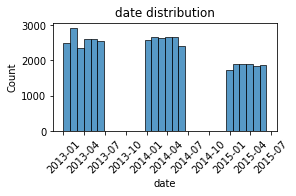

In [502]:
plt.figure(figsize=(4, 2))
sns.histplot(b_df[DATE], bins=30)
plt.xticks(rotation=45)
plt.title('date distribution')

Text(0.5, 1.0, 'shop distribution')

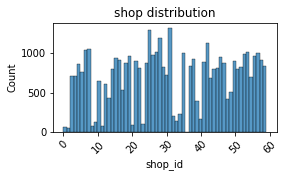

In [503]:
plt.figure(figsize=(4, 2))
sns.histplot(b_df[SHOP], bins=60)
plt.xticks(rotation=45)
plt.title('shop distribution')

Text(0.5, 1.0, 'total price distribution')

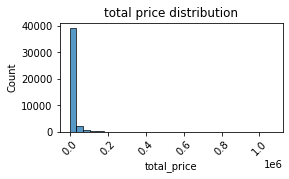

In [504]:
plt.figure(figsize=(4, 2))
sns.histplot(b_df[PSUM], bins=30)
plt.xticks(rotation=45)
plt.title('total price distribution')

Text(0.5, 1.0, 'item count distribution')

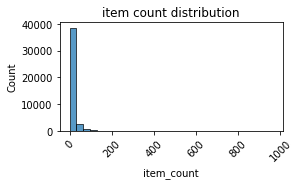

In [505]:
plt.figure(figsize=(4, 2))
sns.histplot(b_df[ICNT], bins=30)
plt.xticks(rotation=45)
plt.title('item count distribution')


Text(0.5, 1.0, 'distinct item count distribution')

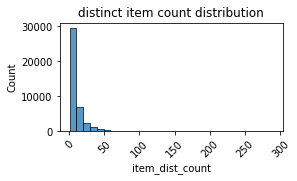

In [506]:
plt.figure(figsize=(4, 2))
sns.histplot(b_df[IDCNT], bins=30)
plt.xticks(rotation=45)
plt.title('distinct item count distribution')

### Item table

In [507]:
i_df = pd.DataFrame()
i_df[ITEM] = total_df.groupby(ITEM)[ITEM].first().astype(int)
i_df[PMAX] = total_df.groupby(ITEM)[PUNIT].max()
i_df[PMIN] = total_df.groupby(ITEM)[PUNIT].min()
i_df[PAVG] = total_df.groupby(ITEM)[PUNIT].mean()
i_df[PVAR] = total_df.groupby(ITEM)[PUNIT].var().fillna(0)
i_df[ICNT] = total_df.groupby(ITEM)[CNT].sum()
i_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98373 entries, -81560 to 22168
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   item_id     98373 non-null  int64  
 1   price_max   98373 non-null  float64
 2   price_min   98373 non-null  float64
 3   price_avg   98373 non-null  float64
 4   price_var   98373 non-null  float64
 5   item_count  98373 non-null  Int64  
dtypes: Int64(1), float64(4), int64(1)
memory usage: 5.4 MB


Text(0.5, 1.0, 'item count distribution')

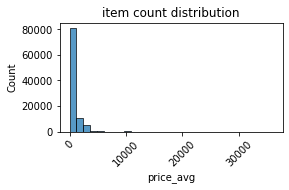

In [508]:
plt.figure(figsize=(4, 2))
sns.histplot(i_df[PAVG], bins=30)
plt.xticks(rotation=45)
plt.title('item count distribution')

<AxesSubplot:>

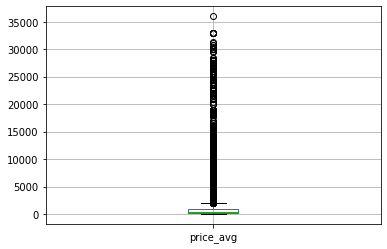

In [509]:
i_df.boxplot(PAVG)


### User table

In [510]:
u_df = pd.DataFrame()
u_df[USER] = total_df.groupby(USER)[USER].first().astype(int)

# Default indicators
u_df[ICNT] = total_df.groupby(USER)[CNT].sum().astype(int)
u_df[IDCNT] = total_df.groupby(USER)[ITEM].nunique()
u_df[MIXB] = b_df.groupby(USER)[ICNT].max()

# Shannon Entropy
def entropy(v):
    relative_f = v.value_counts().values / len(v)
    return - np.sum(relative_f * np.log(relative_f))

u_df[SE] = total_df.groupby(USER).apply(lambda x: entropy(x[SHOP]))
u_df[CE] = total_df.groupby(USER).apply(lambda x: entropy(x[CAT]))
u_df[IE] = total_df.groupby(USER).apply(lambda x: entropy(x[ITEM]))
u_df[PE] = b_df.groupby(USER).apply(lambda x: entropy(x[PSUM]))

# Additional indicators
u_df[MIDXB] = b_df.groupby(USER)[IDCNT].max()
u_df[PSUM] = total_df.groupby(USER)[PSUM].sum().astype(float)
u_df[BCNT] = b_df.groupby(USER).size()
u_df[CCNT] = total_df.groupby(USER)[CAT].nunique()
u_df[SCNT] = total_df.groupby(USER)[SHOP].nunique()
u_df[AIXB] = b_df.groupby(USER)[ICNT].mean()
u_df[ABXVD] = u_df[BCNT] / b_df.groupby(USER)[DATE].nunique()

u_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 824 entries, 1 to 824
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               824 non-null    int64  
 1   item_count            824 non-null    int64  
 2   item_dist_count       824 non-null    int64  
 3   max_items_per_b       824 non-null    int64  
 4   shop_entropy          824 non-null    float64
 5   category_entropy      824 non-null    float64
 6   item_entropy          824 non-null    float64
 7   price_entropy         824 non-null    float64
 8   max_item_dist_per_b   824 non-null    int64  
 9   total_price           824 non-null    float64
 10  basket_count          824 non-null    int64  
 11  category_count        824 non-null    int64  
 12  shop_count            824 non-null    int64  
 13  avg_items_per_basket  824 non-null    float64
 14  avg_baskets_per_d     824 non-null    float64
dtypes: float64(7), int64(8)
memo

array([[<AxesSubplot:title={'center':'item_count'}>,
        <AxesSubplot:title={'center':'item_dist_count'}>,
        <AxesSubplot:title={'center':'max_items_per_b'}>,
        <AxesSubplot:title={'center':'shop_entropy'}>,
        <AxesSubplot:title={'center':'category_entropy'}>],
       [<AxesSubplot:title={'center':'item_entropy'}>,
        <AxesSubplot:title={'center':'price_entropy'}>,
        <AxesSubplot:title={'center':'max_item_dist_per_b'}>,
        <AxesSubplot:title={'center':'total_price'}>,
        <AxesSubplot:title={'center':'basket_count'}>],
       [<AxesSubplot:title={'center':'category_count'}>,
        <AxesSubplot:title={'center':'shop_count'}>,
        <AxesSubplot:title={'center':'avg_items_per_basket'}>,
        <AxesSubplot:title={'center':'avg_baskets_per_d'}>,
        <AxesSubplot:>]], dtype=object)

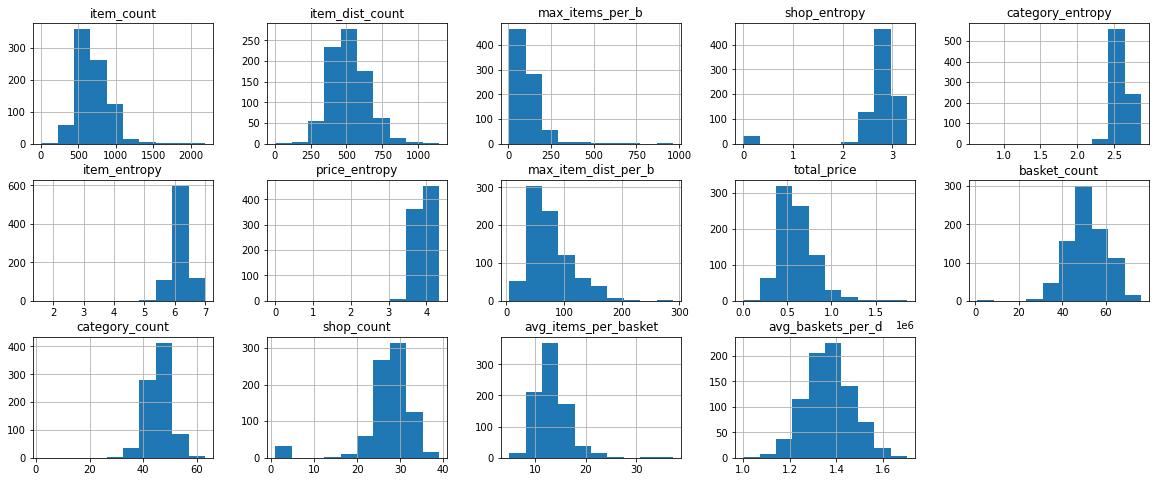

In [511]:
u_df.set_index(USER).hist(layout=(3, 5), figsize=(20, 8), bins=int(np.log2(len(u_df))+1))


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5]),
 [Text(0.5, 0, 'item_count'),
  Text(1.5, 0, 'item_dist_count'),
  Text(2.5, 0, 'max_items_per_b'),
  Text(3.5, 0, 'shop_entropy'),
  Text(4.5, 0, 'category_entropy'),
  Text(5.5, 0, 'item_entropy'),
  Text(6.5, 0, 'price_entropy'),
  Text(7.5, 0, 'max_item_dist_per_b'),
  Text(8.5, 0, 'total_price'),
  Text(9.5, 0, 'basket_count'),
  Text(10.5, 0, 'category_count'),
  Text(11.5, 0, 'shop_count'),
  Text(12.5, 0, 'avg_items_per_basket'),
  Text(13.5, 0, 'avg_baskets_per_d')])

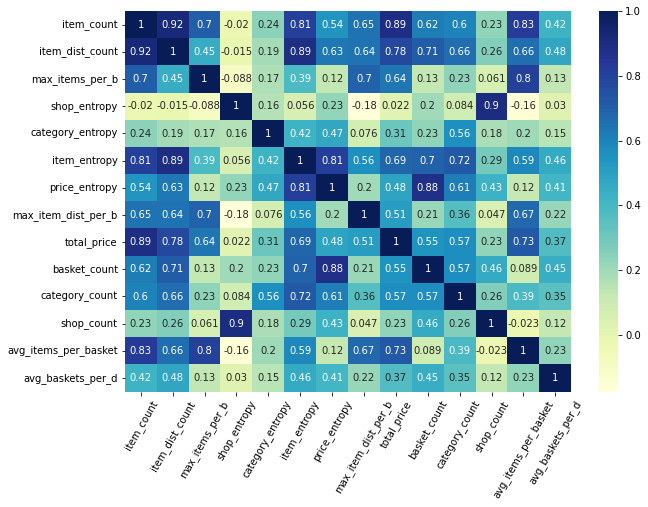

In [512]:
# Pearson correlation of columns describing users
fig, axes = plt.subplots(1, 1, figsize=(10,7))
sns.heatmap(u_df.set_index(USER).corr(), annot=True, cmap="YlGnBu", ax=axes)
plt.xticks(rotation=60)


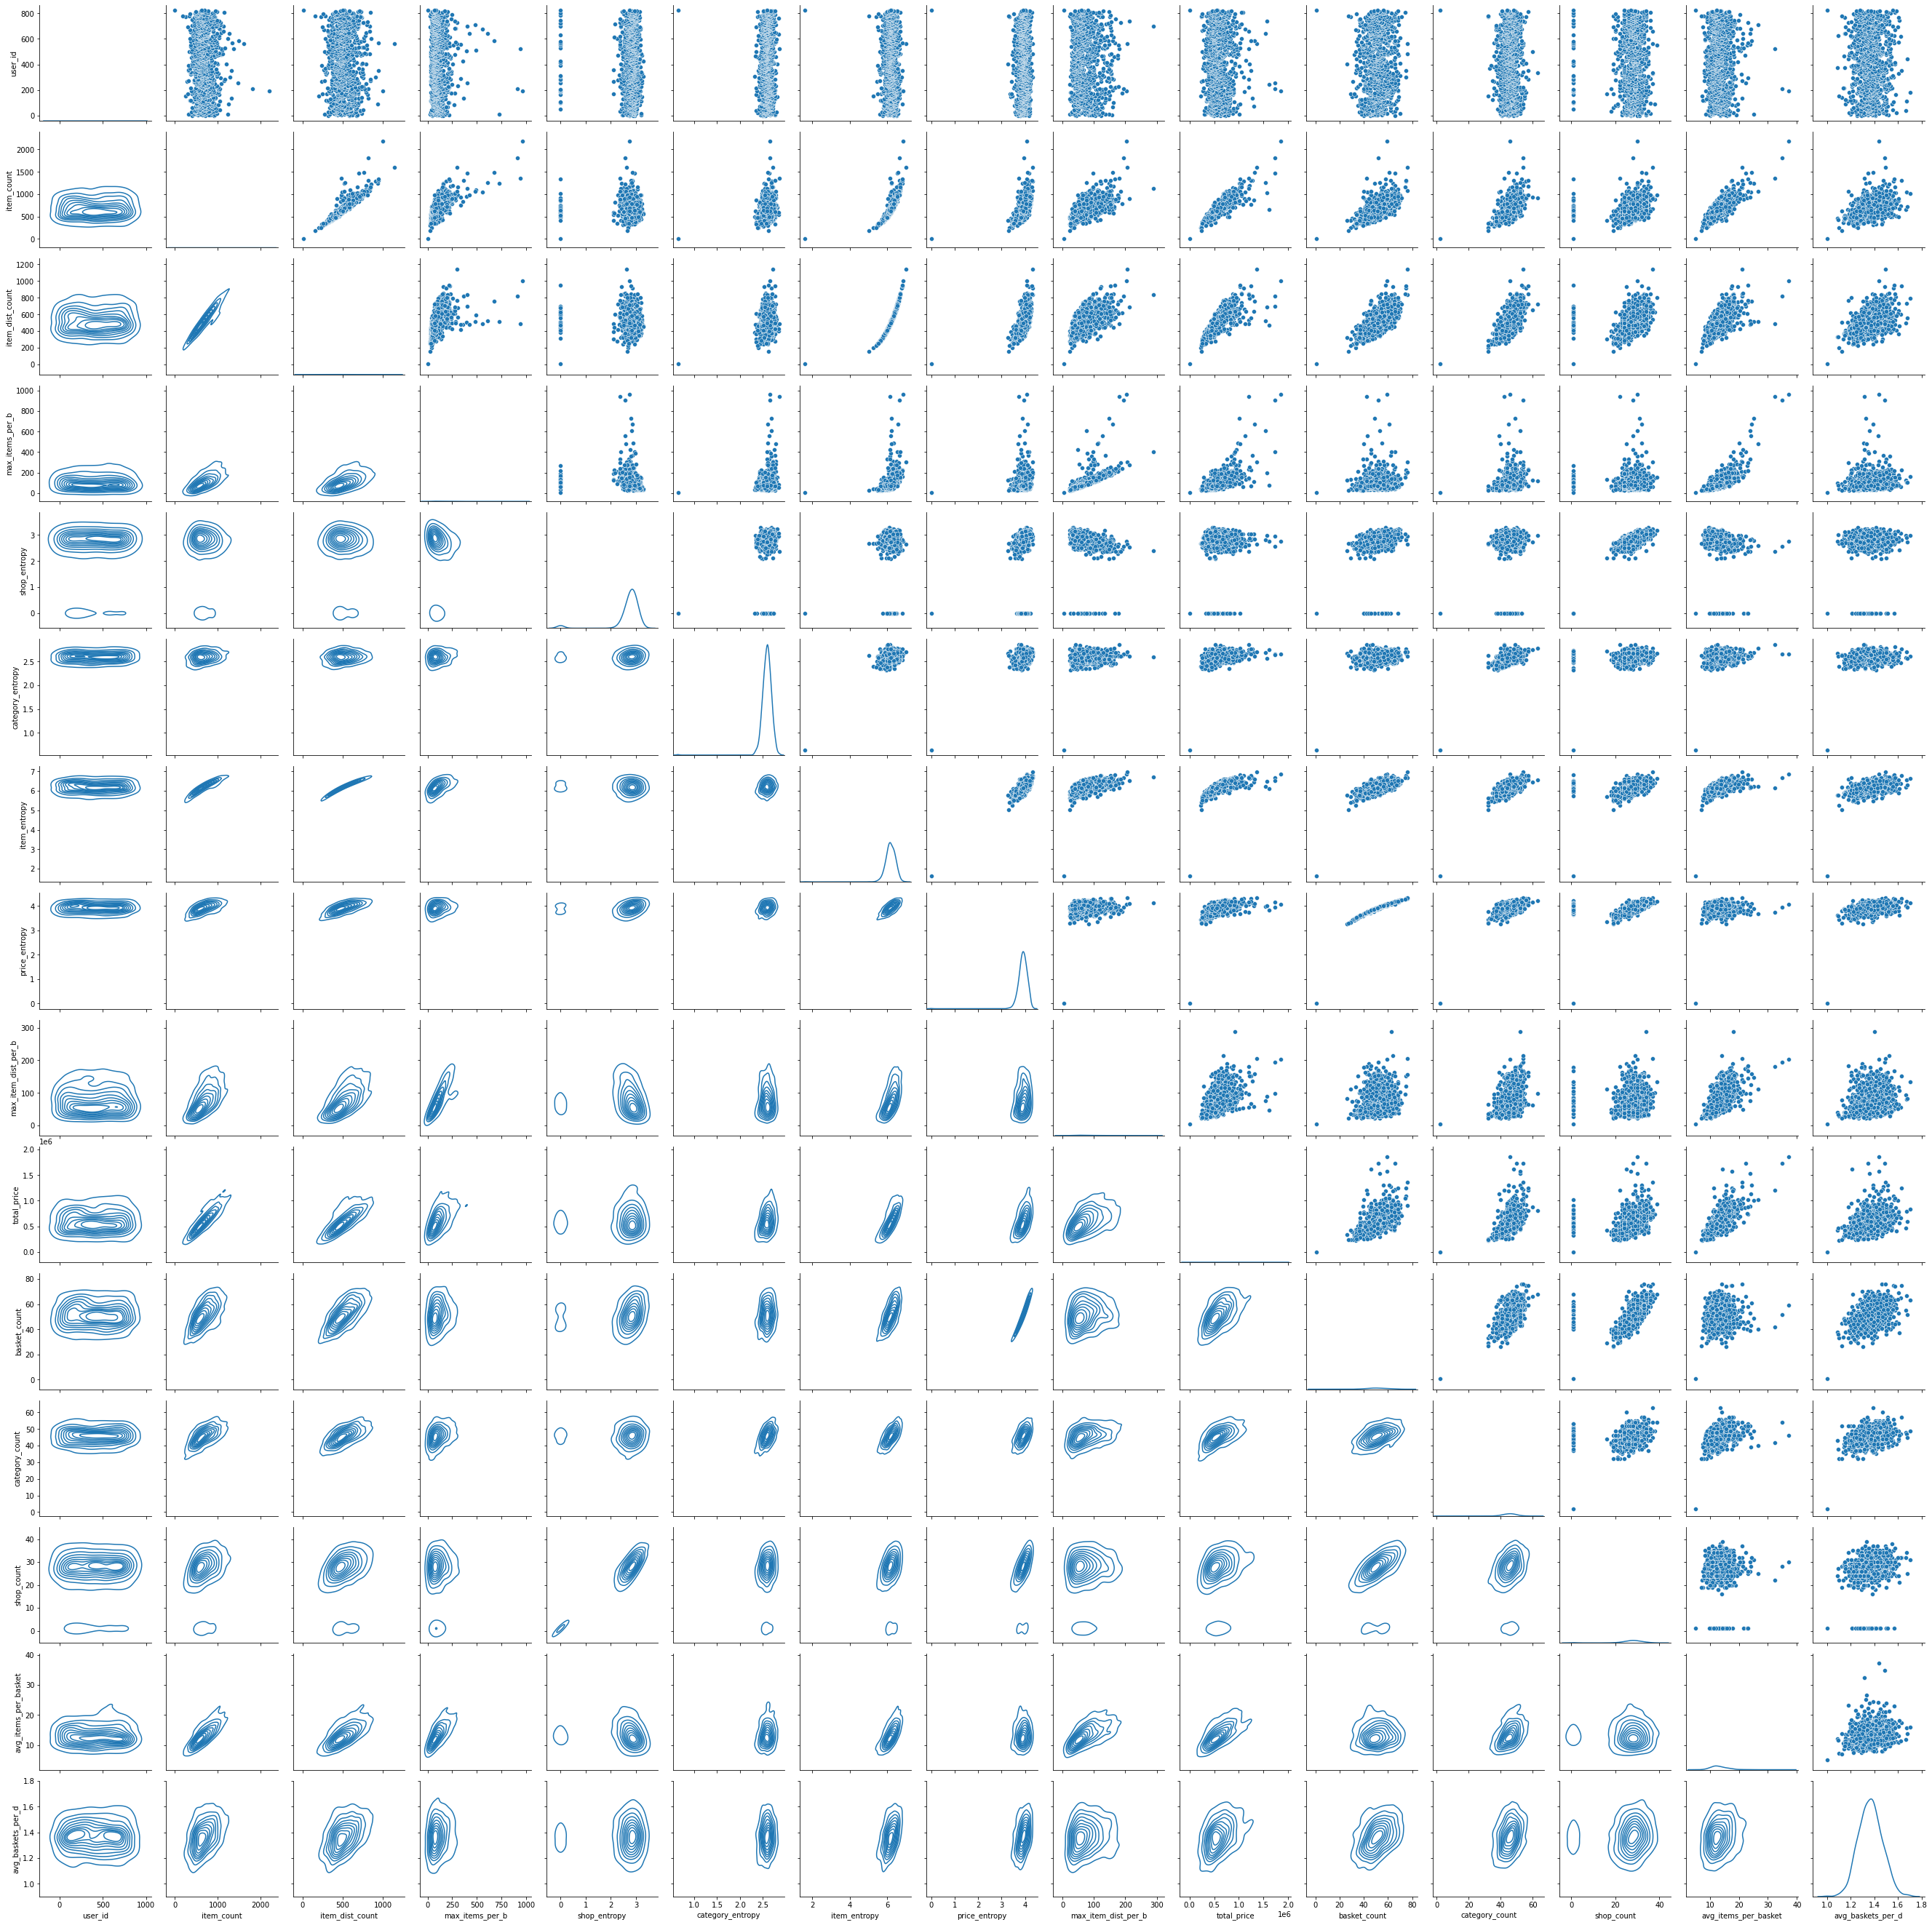

In [513]:
pairgrid = sns.PairGrid(data=u_df)
pairgrid = pairgrid.map_upper(sns.scatterplot)
pairgrid = pairgrid.map_diag(sns.kdeplot)
pairgrid = pairgrid.map_lower(sns.kdeplot)


### Shop table

In [514]:
# make tab for shop (item sold, average price, total sold)
s_df = pd.DataFrame()
s_df[SHOP] = total_df.groupby(SHOP)[SHOP].first().astype(int)
s_df[PSUM] = total_df.groupby(SHOP)[PSUM].sum().astype(float)
s_df[ICNT] = total_df.groupby(SHOP)[CNT].sum().astype(int)
s_df[IDCNT] = total_df.groupby(SHOP)[ITEM].nunique()
s_df[BCNT] = b_df.groupby(SHOP).size()
s_df[CCNT] = total_df.groupby(SHOP)[CAT].nunique()
s_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, 0 to 59
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   shop_id          59 non-null     int64  
 1   total_price      59 non-null     float64
 2   item_count       59 non-null     int64  
 3   item_dist_count  59 non-null     int64  
 4   basket_count     59 non-null     int64  
 5   category_count   59 non-null     int64  
dtypes: float64(1), int64(5)
memory usage: 3.3 KB


### Date table

In [ ]:
# make time series to see spendings over time
d_df = pd.DataFrame(index=total_df[DATE].unique())
d_df[PSUM] = total_df.groupby(DATE)[PSUM].sum().astype(float)
d_df[ICNT] = total_df.groupby(DATE)[CNT].sum().astype(int)
d_df[IDCNT] = total_df.groupby(DATE)[ITEM].count()
d_df[BCNT] = b_df.groupby(DATE).size()
d_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 203 entries, 2013-06-12 to 2013-01-01
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   total_price      203 non-null    float64
 1   item_count       203 non-null    int64  
 2   item_dist_count  203 non-null    int64  
 3   basket_count     203 non-null    int64  
dtypes: float64(1), int64(3)
memory usage: 7.9 KB


In [ ]:
temp_d_df = d_df.reset_index().sort_values('index').rename(columns={'index': 'date'})

In [ ]:
temp_d_df[temp_d_df.date .dt.year == 2014].groupby(temp_d_df.date.dt.day).date.count()

date
1     6
2     6
3     6
4     6
5     6
6     6
7     6
8     6
9     6
10    6
11    6
12    5
Name: date, dtype: int64

<AxesSubplot:title={'center':'Total expenses by year'}>

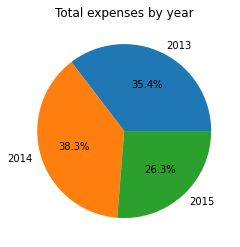

In [ ]:
psum_y = temp_d_df.groupby(temp_d_df.date.dt.year)[PSUM].sum()
psum_y.plot.pie(autopct='%1.1f%%', legend=False, ylabel='', title='Total expenses by year')

<AxesSubplot:title={'center':'Total expenses by month'}>

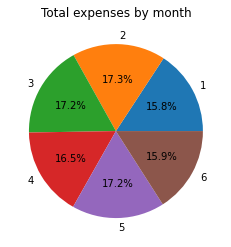

In [ ]:
psum_m = temp_d_df.groupby(temp_d_df.date.dt.month)[PSUM].sum()
psum_m.plot.pie(autopct='%1.1f%%', legend=False, ylabel='', title='Total expenses by month')

<AxesSubplot:title={'center':'Total expenses by day'}>

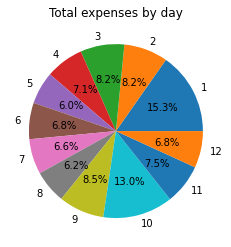

In [ ]:
psum_d = temp_d_df.groupby(temp_d_df.date.dt.day)[PSUM].sum()
psum_d.plot.pie(autopct='%1.1f%%', legend=False, ylabel='', title='Total expenses by day')

<AxesSubplot:title={'center':'Total baskets by year'}>

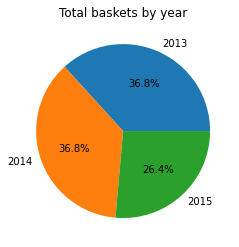

In [ ]:
bcnt_y = temp_d_df.groupby(temp_d_df.date.dt.year)[BCNT].sum()
bcnt_y.plot.pie(autopct='%1.1f%%', legend=False, ylabel='', title='Total baskets by year')

<AxesSubplot:title={'center':'Total baskets by month'}>

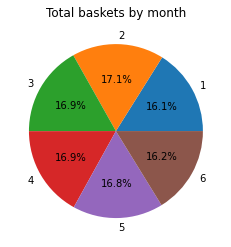

In [ ]:
bcnt_m = temp_d_df.groupby(temp_d_df.date.dt.month)[BCNT].sum()
bcnt_m.plot.pie(autopct='%1.1f%%', legend=False, ylabel='', title='Total baskets by month')

<AxesSubplot:title={'center':'Total baskets by day'}>

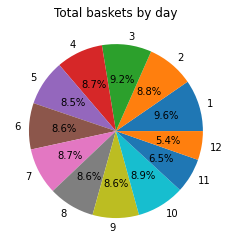

In [ ]:
bcnt_d = temp_d_df.groupby(temp_d_df.date.dt.day)[BCNT].sum()
bcnt_d.plot.pie(autopct='%1.1f%%', legend=False, ylabel='', title='Total baskets by day')

In [ ]:
temp_d_df.groupby(temp_d_df.date.dt.day_of_week).count()

,date,total_price,item_count,item_dist_count,basket_count
date,,,,,
0,29,29,29,29,29
1,30,30,30,30,30
2,29,29,29,29,29
3,26,26,26,26,26
4,29,29,29,29,29
5,30,30,30,30,30
6,30,30,30,30,30


<AxesSubplot:title={'center':'Total expenses by weekday'}>

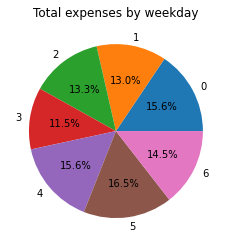

In [ ]:
psum_w = temp_d_df.groupby(temp_d_df.date.dt.weekday)[PSUM].sum()
bcnt_w = temp_d_df.groupby(temp_d_df.date.dt.weekday)[BCNT].sum()
s = psum_w / bcnt_w
s
psum_w.plot.pie(autopct='%1.1f%%', legend=False, ylabel='', title='Total expenses by weekday')